In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Charger les données ===
data = np.load("training_data.npz", allow_pickle=True)
X = np.array(data["data"], dtype=np.float32)  # conversion importante !
feature_labels = data["feature_labels"]

# Charger les labels
y = pd.read_csv("training_labels.csv")
y = y.iloc[:, 0].values 

# ***start of data exploration***

In [99]:
feature_labels 

array(['creatinine', 'urea', 'c_reactive_protein', 'prothrombin_time',
       'total_proteins', 'ast', 'alt', 'alkaline_phosphatase', 'albumin',
       'total_bilirubin', 'ggt', 'unconjugated_bilirubin',
       'conjugated_bilirubin', 'ldh', 'ferritin', 'serum_iron',
       'transferrin_saturation', 'transferrin', 'uric_acid',
       'prothrombin_time', 'creatine_kinase', 'parathyroid_hormone',
       'vitamin_d_25oh_total', 'fasting_glucose', 'serum_folate',
       'vitamin_b12', 'fasting_glucose', 'tsh', 'anti_hbs', 'anti_hcv',
       'hba1c', 'beta_2_microglobulin', 'glucose',
       'high_sensitivity_troponin_t', 'total_psa', 'igg', 'iga', 'igm',
       'hba1c', 'estimated_glomerular_filtration_rate',
       'corrected_calcium', 'inr', 'inr_a', 'potassium', 'sodium',
       'chloride', 'total_co2', 'calcium', 'phosphorus', 'magnesium',
       'hematocrit', 'platelets', 'plasma_cells', 'rdw', 'neutrophils',
       'lymphocytes', 'mchc', 'monocytes', 'myelocytes',
       'granular_ly

In [100]:
import numpy as np
import pandas as pd




# Étape 1.1 — Supprimer les colonnes dupliquées (gardons la première occurrence)
_, unique_indices = np.unique(feature_labels, return_index=True)
unique_indices_sorted = sorted(unique_indices)
X_cleaned = X[:, :, unique_indices_sorted]
feature_names_cleaned = feature_labels[unique_indices_sorted]

# Étape 1.2 — Encodage correct pour 'sex'
sex_idx = np.where(feature_names_cleaned == 'sex')[0][0]
sex_values = X_cleaned[:, :, sex_idx]

# Si sex est codé de manière étrange, on corrige
# Par exemple : valeurs continues ou aberrantes
sex_median = np.nanmedian(sex_values)
sex_values_clean = np.where(sex_values >= sex_median, 1, 0)
X_cleaned[:, :, sex_idx] = sex_values_clean

# Étape 1.3 — Vérifier si d'autres colonnes sont catégorielles (optionnel ici)

# Mise à jour
print(f"✅ Données nettoyées : shape = {X_cleaned.shape}")
print(f"✅ Features uniques restantes : {len(feature_names_cleaned)}")


✅ Données nettoyées : shape = (53652, 12, 74)
✅ Features uniques restantes : 74


In [101]:
X_iqr_cleaned = X_cleaned.copy()  # Reprend le résultat de l’étape 1

for f in range(X_iqr_cleaned.shape[2]):
    feature = X_iqr_cleaned[:, :, f]
    mean = np.nanmean(feature)
    std = np.nanstd(feature)
    lower = mean - 3 * std
    upper = mean + 3 * std
    
    # Remplace les valeurs hors de l'intervalle par NaN
    feature[(feature < lower) | (feature > upper)] = np.nan
    X_iqr_cleaned[:, :, f] = feature

print("✅ Étape 2 terminée : outliers supprimés (mean ± 3*std)")


✅ Étape 2 terminée : outliers supprimés (mean ± 3*std)


In [102]:
X_imputed = X_iqr_cleaned.copy()
for f in range(X_cleaned.shape[2]):
    feature = X_imputed[:, :, f]
    mean = np.nanmean(feature)
    X_imputed[:, :, f] = np.nan_to_num(feature, nan=mean)


In [103]:
# 1. Start from your original data
original_feature_labels = np.array([
    'creatinine', 'urea', 'c_reactive_protein', 'prothrombin_time',
    'total_proteins', 'ast', 'alt', 'alkaline_phosphatase', 'albumin',
    'total_bilirubin', 'ggt', 'unconjugated_bilirubin',
    'conjugated_bilirubin', 'ldh', 'ferritin', 'serum_iron',
    'transferrin_saturation', 'transferrin', 'uric_acid',
    'prothrombin_time', 'creatine_kinase', 'parathyroid_hormone',
    'vitamin_d_25oh_total', 'fasting_glucose', 'serum_folate',
    'vitamin_b12', 'fasting_glucose', 'tsh', 'anti_hbs', 'anti_hcv',
    'hba1c', 'beta_2_microglobulin', 'glucose',
    'high_sensitivity_troponin_t', 'total_psa', 'igg', 'iga', 'igm',
    'hba1c', 'estimated_glomerular_filtration_rate',
    'corrected_calcium', 'inr', 'inr_a', 'potassium', 'sodium',
    'chloride', 'total_co2', 'calcium', 'phosphorus', 'magnesium',
    'hematocrit', 'platelets', 'plasma_cells', 'rdw', 'neutrophils',
    'lymphocytes', 'mchc', 'monocytes', 'myelocytes',
    'granular_lymphocytes', 'erythroblasts', 'hemoglobin',
    'white_blood_cells', 'hyperbasophilic_lymphocytes',
    'red_blood_cells', 'villous_lymphocytes', 'atypical_lymphocytes',
    'mch', 'mcv', 'reticulocytes', 'total_cholesterol',
    'non_hdl_cholesterol', 'hdl_cholesterol', 'triglycerides',
    'measured_ldl_cholesterol', 'patient_age', 'sex'
])

# 2. Remove duplicate feature names (some are repeated in the original)
_, unique_indices = np.unique(original_feature_labels, return_index=True)
unique_feature_labels = original_feature_labels[np.sort(unique_indices)]

# 3. Match this with current shape of your cleaned data
n_features_after_cleaning = X_imputed.shape[2]
final_feature_labels = unique_feature_labels[:n_features_after_cleaning]


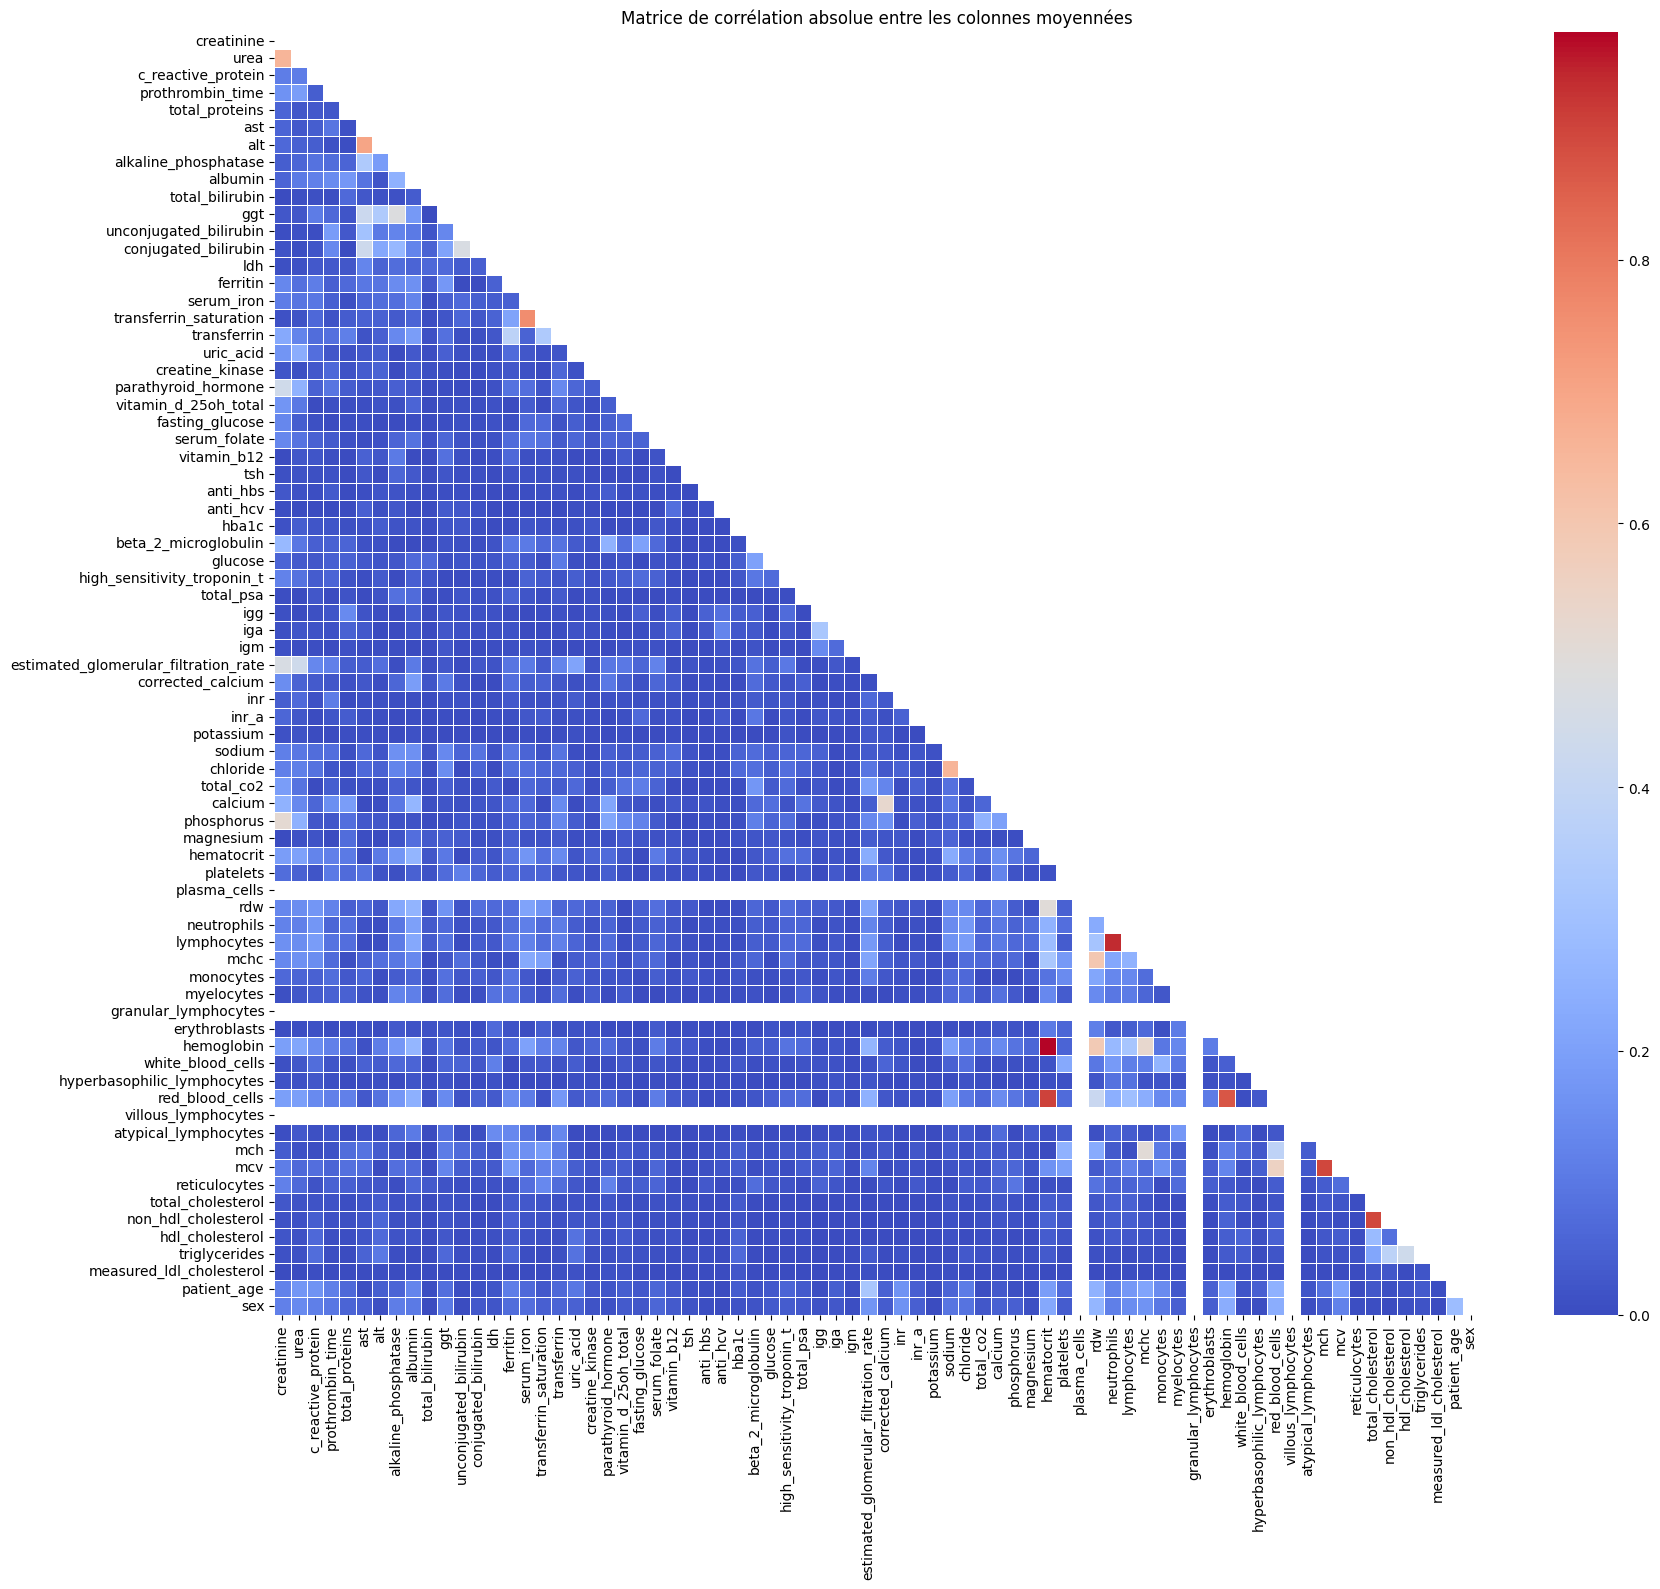

In [104]:
X_avg = np.nanmean( X_imputed, axis=1)

# Créer un DataFrame pour analyse avec noms de colonnes
df_avg = pd.DataFrame(X_avg, columns=final_feature_labels)

# Calcul de la matrice de corrélation
corr_matrix = df_avg.corr().abs()

# Masquer la diagonale
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Affichage en heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation absolue entre les colonnes moyennées")
plt.tight_layout()
plt.show()

# Trouver les paires avec une corrélation > 0.9
high_corr_pairs = []
threshold = 0.9
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Convertir en DataFrame pour tri
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"]).sort_values(by="Correlation", ascending=False)

In [105]:
if not high_corr_df.empty:
    print("📊 Highly correlated feature pairs (corr > 0.9):")
    print(high_corr_df.to_string(index=False))
else:
    print("✅ No feature pairs with correlation above 0.9.")


📊 Highly correlated feature pairs (corr > 0.9):
  Feature 1       Feature 2  Correlation
 hematocrit      hemoglobin     0.972697
neutrophils     lymphocytes     0.938015
 hematocrit red_blood_cells     0.904062


In [106]:
feature_labels_list = list(feature_labels)

to_drop = set()
for f1, f2, corr in high_corr_pairs:
    if f1 not in to_drop and f2 not in to_drop:
        # Keep the one with fewer missing values in the original data
        nan_f1 = np.isnan(X_imputed[:, :, feature_labels_list.index(f1)]).sum()
        nan_f2 = np.isnan(X_imputed[:, :, feature_labels_list.index(f2)]).sum()

        drop_feature = f1 if nan_f1 > nan_f2 else f2
        to_drop.add(drop_feature)


In [107]:
kept_features = [f for f in feature_labels_list if f not in to_drop]
print(f"✅ Final number of features: {len(kept_features)}")
print("🧬 Kept features:")
for f in kept_features:
    print(f)


✅ Final number of features: 74
🧬 Kept features:
creatinine
urea
c_reactive_protein
prothrombin_time
total_proteins
ast
alt
alkaline_phosphatase
albumin
total_bilirubin
ggt
unconjugated_bilirubin
conjugated_bilirubin
ldh
ferritin
serum_iron
transferrin_saturation
transferrin
uric_acid
prothrombin_time
creatine_kinase
parathyroid_hormone
vitamin_d_25oh_total
fasting_glucose
serum_folate
vitamin_b12
fasting_glucose
tsh
anti_hbs
anti_hcv
hba1c
beta_2_microglobulin
glucose
high_sensitivity_troponin_t
total_psa
igg
iga
igm
hba1c
estimated_glomerular_filtration_rate
corrected_calcium
inr
inr_a
potassium
sodium
chloride
total_co2
calcium
phosphorus
magnesium
hematocrit
platelets
plasma_cells
rdw
neutrophils
mchc
monocytes
myelocytes
granular_lymphocytes
erythroblasts
white_blood_cells
hyperbasophilic_lymphocytes
villous_lymphocytes
atypical_lymphocytes
mch
mcv
reticulocytes
total_cholesterol
non_hdl_cholesterol
hdl_cholesterol
triglycerides
measured_ldl_cholesterol
patient_age
sex


In [108]:
final_feature_labels = list(final_feature_labels)
# Get indexes of kept features
kept_indices = [final_feature_labels.index(f) for f in kept_features]

# Apply filtering to the dataset
X_filtered = X_imputed[:, :, kept_indices]


In [109]:
X_scaled = np.zeros_like(X_filtered)
for f in range(X_imputed.shape[2]):
    feature = X_imputed[:, :, f]
    min_val = feature.min()
    max_val = feature.max()
    if max_val != min_val:
        X_scaled[:, :, f] = (feature - min_val) / (max_val - min_val)
    else:
        X_scaled[:, :, f] = 0.0  # or 1.0 if constant


In [110]:
X_filtered.shape[2]

74

In [111]:
print(f"Initial features after removing duplicates: {len(unique_feature_labels)}")
print(f"Final kept features after correlation filter: {len(kept_features)}")
print(f"Dropped due to correlation: {len(unique_feature_labels) - len(kept_features)}")


Initial features after removing duplicates: 74
Final kept features after correlation filter: 74
Dropped due to correlation: 0


In [112]:
np.isnan(X_filtered).sum()


np.int64(0)

In [113]:
for idx, feature in enumerate(final_feature_labels[:3]):  # check more if you want
    vals = X_filtered[:, :, idx].flatten()
    mean = np.nanmean(vals)
    std = np.nanstd(vals)
    lower = mean - 5 * std
    upper = mean + 5 * std
    print(f"{feature}: min={np.nanmin(vals):.2f}, max={np.nanmax(vals):.2f}, expected ∈ [{lower:.2f}, {upper:.2f}]")


creatinine: min=0.00, max=139.00, expected ∈ [1.40, 18.22]
urea: min=0.00, max=4.50, expected ∈ [0.22, 0.65]
c_reactive_protein: min=0.00, max=9532.00, expected ∈ [-1781.29, 5226.31]


# ***end of data exploration***

In [114]:
import numpy as np
from sklearn.preprocessing import StandardScaler




In [115]:
from sklearn.model_selection import train_test_split

# y should be a 1D numpy array of 0/1 labels
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("y shape:", y_train.shape)

Train shape: (42921, 12, 74)
Val shape: (10731, 12, 74)
y shape: (42921,)


In [116]:
from torch.utils.data import Sampler
import random
import numpy as np

class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.pos_indices = np.where(self.labels == 1)[0].tolist()
        self.neg_indices = np.where(self.labels == 0)[0].tolist()
        self.batch_half = batch_size // 2

    def __iter__(self):
        # Shuffle both positive and negative indices each epoch
        random.shuffle(self.pos_indices)
        random.shuffle(self.neg_indices)

        pos_iter = iter(self.pos_indices)
        neg_iter = iter(self.neg_indices)

        while True:
            try:
                pos_batch = [next(pos_iter) for _ in range(self.batch_half)]
                neg_batch = [next(neg_iter) for _ in range(self.batch_half)]
                batch = pos_batch + neg_batch
                random.shuffle(batch)
                yield batch
            except StopIteration:
                break

    def __len__(self):
        return min(len(self.pos_indices), len(self.neg_indices)) // self.batch_half


In [117]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



# Custom Dataset class
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        # Assume X and y are NumPy arrays
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = DiabetesDataset(X_train, y_train)
train_sampler = BalancedBatchSampler(y_train, batch_size=64)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)

val_dataset = DiabetesDataset(X_val, y_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [118]:
import torch
import torch.nn as nn

class ImprovedLSTM(nn.Module):
    def __init__(self, input_size=74, hidden_size=128, num_layers=2, dropout=0.3, bidirectional=True):
        super(ImprovedLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidirectional
        )
        direction_multiplier = 2 if bidirectional else 1
        self.norm = nn.LayerNorm(hidden_size * direction_multiplier)
        self.fc = nn.Linear(hidden_size * direction_multiplier, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        normalized = self.norm(last_output)
        logits = self.fc(normalized)
        return logits.squeeze()


In [119]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probas = torch.sigmoid(inputs)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal_term = (1 - pt) ** self.gamma
        loss = self.alpha * focal_term * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [120]:
import torch

# Count positives and negatives in training set
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

# Compute pos_weight: how much more to weigh the positive class
pos_weight_value = n_neg / n_pos
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

print(f"📊 Positive samples: {n_pos}, Negative samples: {n_neg}")
print(f"⚖️ Using pos_weight = {pos_weight.item():.4f}")


📊 Positive samples: 2714, Negative samples: 40207
⚖️ Using pos_weight = 14.8147


# ***LSTM***

In [121]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, Loss, Optimizer
model = ImprovedLSTM().to(device)
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
# Focal Loss instead of BCEWithLogitsLoss
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


def train_model(train_loader, val_loader, y_train):
    model = ImprovedLSTM().to(device)

    # Compute pos_weight for imbalance
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch = 0, 0
    for epoch in range(1, 31):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [f1_score(y_true, y_prob > t) for t in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_epoch_f1 = max(f1_scores)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)

        if best_epoch_f1 > best_f1:
            best_f1 = best_epoch_f1
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model_lstm.pth")

        scheduler.step(best_epoch_f1)

        print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1@best_thresh: {best_epoch_f1:.4f} | AUC: {auc:.4f}")

    print(f"\n✅ Best F1-score: {best_f1:.4f} achieved at epoch {best_epoch}")
    return model, best_thresh
trained_model, threshold = train_model(train_loader, val_loader, y_train)
# ➤ Call it like this:
# trained_model, threshold = train_model(train_loader, val_loader, y_train)


Epoch 01 | Loss: 44.2146 | Acc: 0.9367 | F1@best_thresh: 0.1526 | AUC: 0.6205
Epoch 02 | Loss: 43.4533 | Acc: 0.9367 | F1@best_thresh: 0.1512 | AUC: 0.6167


KeyboardInterrupt: 

# ***CNN***

In [122]:
import torch
import torch.nn as nn

class ImprovedCNNModel(nn.Module):
    def __init__(self, input_channels=74, kernel_size=3, dropout=0.3):
        super(ImprovedCNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.pool = nn.AdaptiveAvgPool1d(1)  # Global Average Pooling
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # Input shape: (batch, seq_len=12, features=77) → (batch, features, seq_len)
        x = x.permute(0, 2, 1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)  # Shape: (batch, 128)
        x = self.dropout(x)
        x = self.fc(x)
        return x.squeeze()  # Output: (batch,)


In [123]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)
# Focal Loss instead of BCEWithLogitsLoss
criterion = FocalLoss(alpha=1, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure your model and FocalLoss are defined elsewhere
# class DeepCNN(nn.Module): ...
# class FocalLoss(nn.Module): ...

def train_model(train_loader, val_loader, y_train):
    model = ImprovedCNNModel().to(device)

    # Compute pos_weight for imbalance
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    pos_weight = torch.tensor([n_neg / n_pos], dtype=torch.float32).to(device)

    criterion = FocalLoss(alpha=1, gamma=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

    def evaluate(model, dataloader):
        model.eval()
        y_true, y_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                X_batch = X_batch.to(device)
                logits = model(X_batch)
                probs = torch.sigmoid(logits).cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(y_batch.numpy())
        return np.array(y_true), np.array(y_prob)

    best_f1, best_epoch = 0, 0
    for epoch in range(1, 31):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        y_true, y_prob = evaluate(model, val_loader)
        thresholds = np.linspace(0.1, 0.9, 81)
        f1_scores = [f1_score(y_true, y_prob > t) for t in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_epoch_f1 = max(f1_scores)
        acc = accuracy_score(y_true, y_prob > 0.5)
        auc = roc_auc_score(y_true, y_prob)

        if best_epoch_f1 > best_f1:
            best_f1 = best_epoch_f1
            best_epoch = epoch
            torch.save(model.state_dict(), "best_model_cnn.pth")

        scheduler.step(best_epoch_f1)

        print(f"Epoch {epoch:02d} | Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1@best_thresh: {best_epoch_f1:.4f} | AUC: {auc:.4f}")

    print(f"\n✅ Best F1-score: {best_f1:.4f} achieved at epoch {best_epoch}")
    return model, best_thresh
trained_model, threshold = train_model(train_loader, val_loader, y_train)
# ➤ Call it like this:
# trained_model, threshold = train_model(train_loader, val_loader, y_train)


Epoch 01 | Loss: 44.5307 | Acc: 0.9367 | F1@best_thresh: 0.2115 | AUC: 0.7365


KeyboardInterrupt: 

# ***fusion***

In [61]:
lstm_model = ImprovedLSTM().to(device)
cnn_model = ImprovedCNNModel().to(device)

lstm_model.load_state_dict(torch.load("best_model_lstm.pth"))
cnn_model.load_state_dict(torch.load("best_model_cnn.pth"))

lstm_model.eval()
cnn_model.eval()


ImprovedCNNModel(
  (conv1): Conv1d(77, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [62]:
def get_model_probs(model, dataloader):
    probs = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            prob = torch.sigmoid(logits).cpu().numpy()
            probs.extend(prob)
    return np.array(probs)

y_true = []
for _, y_batch in val_loader:
    y_true.extend(y_batch.numpy())
y_true = np.array(y_true)

probs_lstm = get_model_probs(lstm_model, val_loader)
probs_cnn  = get_model_probs(cnn_model, val_loader)


In [63]:
probs_fused = 0.6 * probs_lstm + 0.4 * probs_cnn


In [64]:
thresholds = np.linspace(0.1, 0.9, 81)
f1s = [f1_score(y_true, probs_fused > t) for t in thresholds]
best_thresh = thresholds[np.argmax(f1s)]

final_f1 = max(f1s)
final_acc = accuracy_score(y_true, probs_fused > 0.5)
final_auc = roc_auc_score(y_true, probs_fused)

print(f"\n📊 Fusion Results:")
print(f"AUC: {final_auc:.4f} | Acc: {final_acc:.4f} | Best F1: {final_f1:.4f} @ Threshold: {best_thresh:.2f}")



📊 Fusion Results:
AUC: 0.9148 | Acc: 0.9427 | Best F1: 0.4809 @ Threshold: 0.39
